In [1]:
# asked Calvin for specific parameters

In [2]:
import re
import pandas as pd

# ==== CONFIG ====
CSV_PATH = "/Users/jennaolsen/Downloads/participant_move_sequences.csv"  # <- change this
# The column that identifies the participant (auto-detected below, but you can hard-set if you want)
PARTICIPANT_COL_OVERRIDE = None   # e.g. "Participant" or "Post_Author" or "Author"

# Map long labels to short codes (used if your cells still contain long labels <-- they do not)
THEME_MAP = {
    "Clarification/Communication": "Clarify",
    "Idea Generation": "Idea",
    "Working/TAP": "TAP",
    "Evaluation/Testing": "Evaluate",
    "Meta/Coordination": "Meta",
}

# Allowed tokens after mapping
ALLOWED = {"Clarify", "Idea", "TAP", "Evaluate", "Meta"}

# Minimum sequence length (optional)
MIN_SEQ_LEN = 1
# =================


def detect_participant_col(cols):
    """Pick a likely participant identifier column."""
    candidates = ["participant", "post_author", "author", "name", "user"]
    for c in cols:
        if c.lower() in candidates:
            return c
    # fall back: first column
    return cols[0]


def order_sequence_columns(cols):
    """
    Sort sequence columns so they are in chronological order.
    Uses any integer suffix if present (e.g., Step1, Move_2).
    Falls back to lexical order for ties / no numbers.
    """
    def key(c):
        m = re.search(r'(\d+)', str(c))
        # Prefer columns with numbers first, then by that number, then by the name
        return (0 if m else 1, int(m.group(1)) if m else 10**9, str(c))
    return sorted(cols, key=key)


def normalize_token(x):
    """Stringify, strip, map long→short if present."""
    if pd.isna(x):
        return None
    s = str(x).strip()
    if not s:
        return None
    # map long → short if exact match in THEME_MAP
    if s in THEME_MAP:
        s = THEME_MAP[s]
    return s


# ---- Load data ----
df = pd.read_csv(CSV_PATH)

# Identify participant column
participant_col = PARTICIPANT_COL_OVERRIDE or detect_participant_col(df.columns)

# Identify sequence columns = all non-participant columns
seq_cols = [c for c in df.columns if c != participant_col]
seq_cols = order_sequence_columns(seq_cols)

# ---- Build sequences dict: {participant: [tokens...]} ----
sequences = {}
unexpected_values = set()

for _, row in df.iterrows():
    pid = str(row[participant_col]).strip()
    tokens = []
    for col in seq_cols:
        t = normalize_token(row[col])
        if t is None:
            continue
        # If cell already short-coded, keep; else check map result
        if t not in ALLOWED:
            # try a case-normalization pass (e.g., "tap" → "TAP")
            t_try = t.capitalize() if t.lower() in {"clarify", "idea", "evaluate", "meta"} else t
            if t.upper() == "TAP":
                t_try = "TAP"
            if t_try in ALLOWED:
                t = t_try
            else:
                unexpected_values.add(t)
                # skip or keep? Here we skip truly unexpected tokens
                continue
        tokens.append(t)
    if len(tokens) >= MIN_SEQ_LEN:
        sequences[pid] = tokens

# ---- Sanity report ----
print(f"Participants parsed: {len(sequences)}")
print(f"Median sequence length: {pd.Series([len(v) for v in sequences.values()]).median()}")
if unexpected_values:
    print("⚠️ Unexpected values encountered (skipped). Consider extending THEME_MAP or checking the CSV:")
    print(sorted(list(unexpected_values))[:50])

# Example: show a few sequences
list(sequences.items())[:5]

# Optional: also build space-joined strings (useful for Levenshtein-on-strings approach)
token_strings = {p: " ".join(seq) for p, seq in sequences.items()}
list(token_strings.items())[:3]


Participants parsed: 118
Median sequence length: 1.0


[('Alexander Woo', 'TAP'), ('Amir', 'TAP'), ('Andreas Varnavides', 'TAP')]

In [3]:
#Levenshtein distance calculation
import numpy as np
import textdistance

participants = list(sequences.keys())
n = len(participants)
lev_matrix = np.zeros((n, n))

for i in range(n):
    for j in range(i+1, n):
        dist = textdistance.levenshtein.distance(sequences[participants[i]], sequences[participants[j]])
        lev_matrix[i, j] = dist
        lev_matrix[j, i] = dist

In [4]:
%pip install fastdtw

Note: you may need to restart the kernel to use updated packages.


In [5]:
import fastdtw
#DTW clustering - requires integer transformation of tokens 
from fastdtw import fastdtw

# Map tokens to integers
token_to_id = {'Clarify':0, 'Idea':1, 'TAP':2, 'Evaluate':3, 'Meta':4}
seq_ids = {p: [token_to_id[t] for t in seq] for p, seq in sequences.items()}

# Custom 0/1 mismatch cost
def hamming_cost(a, b):
    return 0.0 if a == b else 1.0

participants = list(seq_ids.keys())
n = len(participants)
dtw_matrix = np.zeros((n, n))

for i in range(n):
    for j in range(i+1, n):
        d, _ = fastdtw(seq_ids[participants[i]], seq_ids[participants[j]], dist=hamming_cost)
        dtw_matrix[i, j] = dtw_matrix[j, i] = d

In [6]:
import matplotlib

# Set the font globally
matplotlib.rc('font', family='Devanagari Sangam MN') # Replace 'Your Devanagari Font Name'
matplotlib.rc('font', size=12) # Adjust font size as needed

/Applications/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 246 (\N{LATIN SMALL LETTER O WITH DIAERESIS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


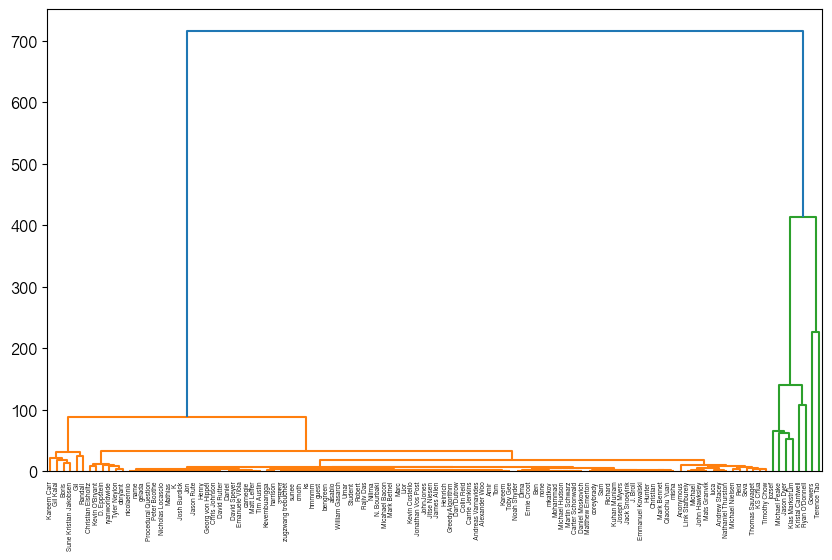

In [7]:
#Hierarchical clustering
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# Convert distance matrix into condensed form for SciPy
from scipy.spatial.distance import squareform
condensed = squareform(lev_matrix)
# condensed = squareform(dtw_matrix)

# Ward’s linkage
Z = linkage(condensed, method='ward')

# Dendrogram
plt.figure(figsize=(10, 6))
dendrogram(Z, labels=participants, leaf_rotation=90)
plt.show()

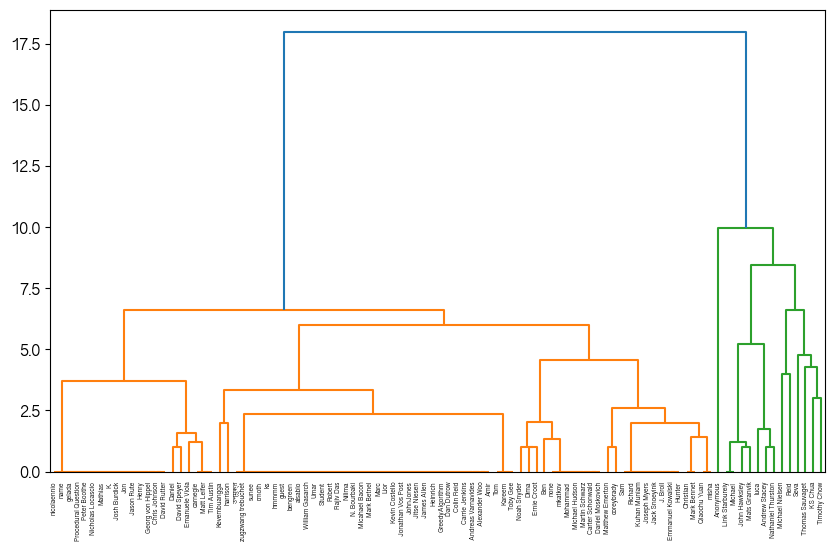

In [8]:
#Removing key groups by iterating through & visually removing from list
participants = list(sequences.keys())
#Removing hosts
participants.remove("Gowers")
participants.remove("Terence Tao")
#Removing cluster 1
participants.remove("Kristal Cantwell")
participants.remove("Ryan O'Donnell")
#Removing cluster 2
participants.remove("jozsef")
participants.remove("Michael Peake")
participants.remove("Jason Dyer")
participants.remove("Klas Markström")
#Removing cluster 3a
participants.remove("Gil")
participants.remove("Randall")
#Removing cluster 3b
participants.remove("Kareem Carr")
participants.remove("Gil Kalai")
participants.remove("Boris")
participants.remove("Sune Kristian Jakobsen")
#Removing cluster 4a
participants.remove("Kevin O'Bryant")
participants.remove("Christian Elsholtz")
#Removing cluster 4b
participants.remove("D. Eppstein")
participants.remove("ryanworldwide")
participants.remove("Tyler Neylon")
participants.remove("obryant")

# print(participants)

n = len(participants)
lev_matrix = np.zeros((n, n))

for i in range(n):
    for j in range(i+1, n):
        dist = textdistance.levenshtein.distance(sequences[participants[i]], sequences[participants[j]])
        lev_matrix[i, j] = dist
        lev_matrix[j, i] = dist
        
# Convert distance matrix into condensed form for SciPy
from scipy.spatial.distance import squareform
condensed = squareform(lev_matrix)
# condensed = squareform(dtw_matrix)

# Ward’s linkage
Z = linkage(condensed, method='ward')

# Dendrogram
plt.figure(figsize=(10, 6))
dendrogram(Z, labels=participants, leaf_rotation=90)
plt.show()